<a href="https://colab.research.google.com/github/ai-fast-track/timeseries/blob/master/nbs/cam_tutorial_ECG200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference (Predictions)
> Predicting a test dataset for the ECG200 univariate time series dataset using an exported model

In [ ]:
# !pip install git+https://github.com/fastai/fastai2 
# !pip install git+https://github.com/fastai/fastcore 
# !pip install git+https://github.com/ai-fast-track/timeseries.git

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [ ]:
from fastai2.basics import *

In [ ]:
# hide
# Only for Windows users because symlink to `timeseries` folder is not recognized by Windows
import sys
sys.path.append("..")

In [ ]:
from timeseries.all import *

In [ ]:
from ipywidgets import interact, interactive, IntSlider, Layout
import ipywidgets as widgets
from IPython.display import display

# Cardiologist of Day: Test your skill to detect Myocardial Infarction?
> Test your skill in differentiating Normal Heart Beat and Myocardial Infarction (heart attack) signal.

## ECG Dataset
> This dataset was formatted by R. Olszewski as part of his thesis
“Generalized feature extraction for structural	pattern recognition
in time-series data,” at Carnegie Mellon University, 2001. Each
series traces the electrical activity recorded during one
heartbeat. The two classes are a normal heartbeat and a Myocardial
Infarction. Cardiac ischemia refers to lack of blood flow and oxygen to the heart muscle. If ischemia is severe or lasts too long, it can cause a heart attack (myocardial infarction) and can lead to heart tissue death. 	

![](images/ECG200.png)

In [ ]:
fname = Path('ECG200_TEST.arff')
data = TSData.from_arff([fname])
items = data.get_items()

In [ ]:
# items[0]

In [ ]:
sample =  data.sample(1)
# sample

In [ ]:
n_samples = data.get_nb_samples()
n_samples

100

In [ ]:
def get_preds(idx):
    test_dl = dls.test_dl([items[idx]], with_labels=True)
    return (test_dl, learn.get_preds(dl=test_dl))  

In [ ]:
# i2o() function
# Converting CategoryTensor label into the human-readable label
lbl_dict = dict([
    (0, 'Normal Heart Beat'),   
    (1, 'Myocardial Infarction')]
)
def i2o(y):
    return lbl_dict.__getitem__(y.data.item())
    # return lbl_dict.__getitem__(int(dls.tfms[1][1].decodes(y)))

In [ ]:
def get_preds_and_confidence(preds):
    predictions = []
    confidences = []
    for index, item in enumerate(preds[0]): 
#         prediction = dls.categorize.decode(np.argmax(item)).upper() 
        prediction = i2o(np.argmax(item)) 
        val = float(max(item))*100
        percent = round(val, 2) #f'Confidence: {val:.2f}%'
        predictions.append(prediction)
        confidences.append(percent)
#         print(f"Prediction: {prediction} - Confidence: {percent} - tserie = {test_dl.items[index][1]}")
    return predictions, confidences


## Importing a model

In [ ]:
path = Path()
path.ls(file_exts='.pkl'), path
learn = load_learner(path/'export.pkl')
dls = learn.dls

In [ ]:
dls.vocab

(#2) ['-1','1']

In [ ]:
# dls.o2i('1')
dls.tfms[1][1].encodes('1')

TensorCategory(1)

In [ ]:
def display_sample(idx):
    ts, label = data[idx]
    show_timeseries(ts, title='Your Guess\n Confidence', figsize=(8.4,6.45), linewidth=4, color='orange', leg=False)

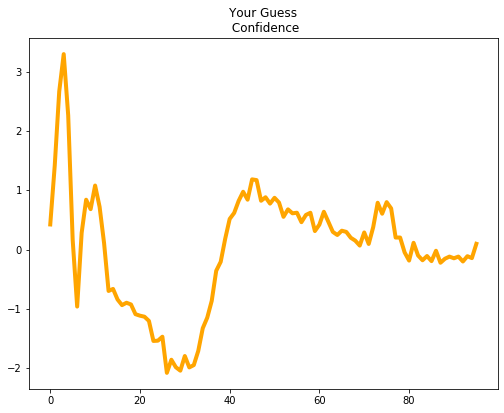

In [ ]:
display_sample(0)

In [ ]:
def show_preds(idx):
    test_dl, preds = get_preds(idx)
    predictions, confidences =  get_preds_and_confidence(preds)
    batch=test_dl.one_batch()
    fig = show_cam(batch, learn.model, layer=5, i2o=i2o, multi_fig=True, cmap=CMAP.jet, confidence=confidences, figsize=(8,6))
    return (predictions, confidences)

In [ ]:
idx_slider =IntSlider(value=0,min=0,max=n_samples-1,step=1, description='Index')
ts_curve = widgets.interactive(display_sample, idx=idx_slider)

# Set the height of the control.children[-1] so that the output does not jump and flicker
output = ts_curve.children[-1]
# output.layout.height = '500px'
# output.layout.width = '1000px'

# ts_curve

In [ ]:
# display_sample(idx_slider.value)

In [ ]:
# [items[idx_slider.value]]

In [ ]:
guest_prediction_lbl = widgets.Label(value="Guest Prediction:")
guest_confidence_lbl = widgets.Label(value="Guest Confidence (%):")


In [ ]:
guest_prediction = widgets.RadioButtons(
    options=['Normal Heart Beat', 'Myocardial Infarction'],
#    value='Normal Heart Beat', # Defaults to 'Normal Heart Beat'
   layout={'width': 'max-content'}, # If the items' names are long
#     description='Your Prediction:',
    disabled=False
)

In [ ]:
guest_confidence = widgets.IntSlider(min=-0, max=100, step=1, value=80)

In [ ]:
def validate_guess(model_prediction, model_confidence, guest_prediction, guest_confidence):
    if model_prediction != guest_prediction: 
        return 'Your guess is incorrect. Please try again!'
    else:
        if guest_confidence >= model_confidence: 
            return 'Congratulations! You beat the neural network!'
        else:
            return 'Good guess! But the neural network is more confident in its prediction than you!'
    

## App

In [ ]:
#App Title
app_title = widgets.HTML("<h1 align=center style='color:greenyellow; line-height: 40px; font-size:46px; font-weight: bold; font-family: 'Roboto''>Cardiologist of the Day</h1>")

In [ ]:
# Score Panel
style={'font_size': '1em', 'font_weight': 'bold', 'color': 'red'}
style={'font_weight': 'bold'}
# layout=Layout(width='auto', grid_area='header')
# style={'color:greenyellow; font-size:3em'}
# guest_score_lbl = widgets.Label(value="Your Score", style={'font_weight': 'bold'})
# guest_score_lbl.add_class("mytext")
# guest_score_lbl.style.font_size = '2em'

guest_score_lbl = widgets.HTML("<h3 style='color:#A60000; line-height: 40px; font-size:39px; font-weight: bold; font-family: 'Roboto';>Your Score</h3>")
# guest_score_val = widgets.Label(value="0", style=style)
guest_score_val = widgets.HTML("<h3 style='color:black; line-height: 40px; font-size:39px; font-weight: bold; font-family: 'Roboto';>0</h3>")
guest_score_box = widgets.VBox([guest_score_lbl, guest_score_val], style=style)

nn_score_lbl = widgets.HTML("<h3 style='color:#A60000; line-height: 40px; font-size:39px; font-weight: bold; font-family: 'Roboto';>Neural Net Score</h3>")
nn_score_val = widgets.HTML("<h3 style='color:black; line-height: 40px; font-size:39px; font-weight: bold; font-family: 'Roboto';>0</h3>")
nn_score_box = widgets.VBox([nn_score_lbl, nn_score_val])

score_box = widgets.HBox([guest_score_box, nn_score_box]) # , style={'font-size': '3em'}

In [ ]:
# nn_verdict_wg = widgets.HTML(f"<h3 style='color:#A60000; line-height: 40px; font-size:39px; font-weight: bold; font-family: 'Roboto';>Verdict</h3>")
nn_verdict_wg = widgets.HTML(
    value='',
    layout=Layout(width='auto', height='auto')
)

In [ ]:
# Guess Button
item_layout = widgets.Layout(height='30px', min_width='300px')
btn_guess = widgets.Button(description="Score",  button_style='info', layout=item_layout)

# btn_guess = widgets.Button(description="Score")
btn_guess.style.button_color = 'greenyellow'
btn_guess.style.font_weight = '1000'
btn_guess.style.font_size = '40px'

In [ ]:
def show_cam_out(idx):
    predictions, confidences = show_preds(idx)
    model_prediction = predictions[0]
    model_confidence = confidences[0]
    g_p = guest_prediction.value
    g_c = guest_confidence.value
    
    _, label = data[idx]
    encoded_label = dls.tfms[1][1].encodes(label)

    verdict_str = validate_guess(model_prediction, model_confidence, g_p, g_c)
    nn_verdict_wg.value = verdict_str
    # print(verdict_str)

In [ ]:
# cam_out = widgets.interactive(display_cam, idx=idx_slider)

In [ ]:
# cam_created = False

In [ ]:
# def on_btn_guess_clicked(b):        
#     if cam_created == True:
#         cam.update(show_cam_out(idx_slider.value))
#         # print(verdict_str)
#         cam_created = True
#     else:
#         cam = display(show_cam_out(idx_slider.value), display_id=True)
        
# btn_guess.on_click(on_btn_guess_clicked)

In [ ]:
cam = widgets.Output()

def on_btn_guess_clicked(b):
    with cam:
        cam.clear_output()
        show_cam_out(idx_slider.value)

btn_guess.on_click(on_btn_guess_clicked)

In [ ]:
# def on_btn_guess_clicked(b):
#     with ts_curve.Output:
#         ts_curve.Output.clear_output()
#         predictions, confidences = show_preds(idx_slider.value)
#         model_prediction = predictions[0]
#         model_confidence = confidences[0]
#         g_p = guest_prediction.value
#         g_c = guest_confidence.value

#         verdict_str = validate_guess(model_prediction, model_confidence, g_p, g_c)
#         nn_verdict_wg.value = verdict_str
#         # print(verdict_str)

# btn_guess.on_click(on_btn_guess_clicked)

In [ ]:
# Guess Selection Panel
guess_pred = widgets.VBox([guest_prediction_lbl, guest_prediction])
guess_conf = widgets.VBox([ guest_confidence_lbl, guest_confidence])
guess_comp = widgets.HBox([guess_pred, guess_conf, btn_guess])

In [ ]:
# Original curv
score_out = widgets.HBox([ts_curve, cam])

In [ ]:
style = """
    <style>
       .widget-vbox {
            width: 900px
            padding-top: 20px;
            padding-right: 0px;
            padding-bottom: 20px;
            padding-left: 10px;
       }
       
       .output_wrapper .output_scroll {
            height: unset !important;
            border-radius: unset !important;
            -webkit-box-shadow: unset !important;
            box-shadow: unset !important;
        }
    </style>
    """
display(widgets.HTML(style))

HTML(value='\n    <style>\n       .widget-vbox {\n            width: 900px\n            padding-top: 20px;\n  …

In [ ]:
# app_wg = widgets.VBox([app_title, ts_curve, score_box, guess_comp, score_out])
widgets.VBox([app_title, score_box, guess_comp, score_out, nn_verdict_wg])

# output = app_wg.children[-1]
# output.layout.height = '1000px'
# output.layout.width = '1000px'

# app_wg

In [ ]:
# widgets.VBox([app_title, score_box, guess_comp, score_out])

In [ ]:
# guess_pred = widgets.VBox([guest_prediction_lbl, guest_prediction])
# guess_conf = widgets.VBox([ guest_confidence_lbl, guest_confidence])
# guess_input = widgets.VBox([guess_pred, guess_conf])

In [ ]:
# nn_verdict_wg.layout.visibility = 'visible'
# widgets.AppLayout(header=app_title,
#           left_sidebar=guess_input,
#           center=score_out,
#           right_sidebar=ts_curve,
#           footer=nn_verdict_wg,
#           pane_widths=[3, 3, 1],
#           pane_heights=[1, 5, '60px'])

![](images/montreal-pont-jacques-cartier.jpg)
